In [ ]:
# Import all necessary libraries 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#import warnings
#warnings.filterwarnings("ignore")

# Data Exploration

In [ ]:
# Load data
data = pd.read_csv("./dataset.csv")
data = data.astype(int)
data

### Data types exploration

In [ ]:
data_types = data.dtypes
data_types

# Data preprocessing and visualisation

### Dublicates. Missing Values and Outliers

In [ ]:
#check data's integrity
data.duplicated()
int(data.duplicated().sum())


This are a lot of duplicates but I assume that this happens verry quick, even if it is really a different patient, with such a huge amount of categorical 2 group variables. Because of this it would be bad to drop dublicates and keep respectively the first of them.

In [ ]:
#check for missing values
data.isna().sum(axis=1)
data.isna().any(axis=1).any()

<- no missing values

Features and Label

In [ ]:
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']
X.shape

Compute correlation matrix

In [ ]:
corr_matrix = X.corr().abs() #abs trat negative values same as positive
corr_matrix

Plot correlation matrix

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

Remove higly correlated variables

In [ ]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9 (threshold is adjustable)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop redundant features
X_reduced = X.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")

Use mutual information filter methods to quantify the amount of information that one variable provides about another

In [ ]:
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

Let's try backword stepwise elimination (with multinominal logistische regression)

In [ ]:
import statsmodels.api as sm

#Add constant for intercept
def multinomial(X): 
    X = sm.add_constant(X)
    cols = list(X.columns)
    pmax = 1

    while len(cols) > 0:
        # Inside your while loop:
        model = sm.MNLogit(y, X[cols]).fit(disp=0)

        # Take max p-value per feature across classes
        p_values = model.pvalues
        p_values_max = p_values.max(axis=1)
        pmax = p_values_max.max()
        feature_with_p_max = p_values_max.idxmax()

        # Backward elimination step
        if pmax > 0.05:
            print(f"Dropping '{feature_with_p_max}' with p = {pmax:.4f}")
            cols.remove(feature_with_p_max)
        else:
            break

    print(f"Selected features: {cols}")
    return cols

X_BSE_list = multinomial(X)
X_BSE_list.remove('const')
X_postBSE = X[X_BSE_list]


LABEL, CATEGORICAL AND NUMERICAL FEATURES

**Numerical (Interval data** <- has no meaningful zero **) :** 
BMI

**Categorical (Ordinal data) :**
Diabetes_012, Age, GenHlth, MentHlth, PhyaHlth, Education, Income) 

**Categorical (Nominal data) :** Rest 
-> (HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex) 

In [ ]:
label = ['Diabetes_012']
num_cols = ['BMI', 'Age']
cate_cols = data.columns.drop(['BMI', 'Age', 'Diabetes_012'])

### Data Visualisation

Distribution label Diabetes:

In [ ]:
plt.figure(figsize=(12, 10))
sns.countplot(data=data, x='Diabetes_012')
plt.title('Distribution of Diabetes_012')
plt.show()

For the numerical features. See if there is a difference between Diabetes_012

In [ ]:
for i in range(len(num_cols)):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x='Diabetes_012', y=num_cols[i])
    plt.show()

Many outliers in BMI?

In [ ]:
#Suggestion from Noemi:


➡ **Box Plot:** Use a box plot to show the data distribution and identify **outliers**. This type of chart works well when you have a lot of data and want to see the range and median of the data. A box-and-whisker plot displays the summary of a set of data:  the minimum, first quartile, median, third quartile, and maximum of the data subset. 

➡**Violin plots**: Use a box plot to visualize distribution and probability.  This hybrid chart works  version to shows the full distribution of the data and the peaks in the numeric dataset.  

➡ **Bar Chart:** Use a bar chart to compare categories or groups. This chart type works well when the data is discrete and not continuous.

Look at the distribution of every categorical variable

In [ ]:
for col in cate_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data, x=col, hue='Diabetes_012')
    plt.title(f'{col} vs Diabetes')
    plt.show()


In [ ]:
#for age as a categorical variable
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Age', hue='Diabetes_012')
plt.title('Age Groups vs Diabetes')
plt.show()

 

# Machine Learning Algorithms

## Logistic Regression

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, make_scorer, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv("./dataset.csv")
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']

In [3]:
# === 2. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# === Set up scaling only for ordinal/continuous columns ===
ordinal_col = ['GenHlth', 'PhysHlth', 'MentHlth','Education', 'Income', 'BMI', 'Age']
binary_col = [col for col in X.columns if col not in ordinal_col]

preprocessor = ColumnTransformer([
    ('scale_ordial', StandardScaler(), ordinal_col), 
    ('pass_binaries', 'passthrough', binary_col) # binary left untouched
    ])  

Feature Selection I (SelectKBest, f_classif, with k tuning)

In [ ]:
pipeline_kbest = Pipeline([
    ('preprocessing', preprocessor),
    ('select', SelectKBest(score_func=f_classif)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

param_grid = {
    'select__k': list(range(1, 22))  # Try all k values from 1 to 21
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline_kbest,
    param_grid,
    scoring='f1_macro',  # Or 'recall_macro', etc.
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

results_df = pd.DataFrame(grid.cv_results_)[['param_select__k', 'mean_test_score', 'mean_train_score']]
results_df.columns = ['k', 'Test Score (F1)', 'Train Score (F1)']
results_df.sort_values('Test Score (F1)', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

In [ ]:
pipeline1 = Pipeline([
    ('preprocessing', preprocessor),
    ('select', SelectKBest(score_func=f_classif, k=17)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipeline1.fit(X_train, y_train)
y_pred = pipeline1.predict(X_test)
f1_kbest = f1_score(y_test, y_pred, average='macro')

print(classification_report(y_test, y_pred))
print(f"F1 Score:  {f1_kbest:.4f}")

Feature Selection II (backwards stepwise elimination)

In [ ]:
selected_features = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income'] #X_BSE_list
ordinal_cols_reduced = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
binary_cols_reduced = [col for col in selected_features if col not in ordinal_cols_reduced]
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

preprocessor2 = ColumnTransformer(transformers=[
    ('scale_ordinals', StandardScaler(), ordinal_cols_reduced),
    ('pass_binaries', 'passthrough', binary_cols_reduced)
])
pipeline2 = Pipeline([
    ('preprocessing', preprocessor2), 
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipeline2.fit(X_train_reduced, y_train)

y_pred = pipeline2.predict(X_test_reduced)
f1_BSE = f1_score(y_test, y_pred, average='macro')

print(classification_report(y_test, y_pred))
print(f"F1 Score:  {f1_BSE:.4f}")

Hyperparameter tuning

In [ ]:
# === try saga with elasticnet ===
param_grid = {
    'clf__penalty': ['elasticnet'],
    'clf__solver': ['saga'],  # Must match penalty type
    'clf__max_iter': [5000],
    'clf__l1_ratio': [0.1,0.5,0.9]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline1,
    param_grid,
    scoring='f1_macro', 
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

In [ ]:
# === try saga with other penalties ===
param_grid = {
    'clf__penalty': ['l1','l2',None],
    'clf__solver': ['saga'],  # Must match penalty type
    'clf__max_iter': [5000],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline1,
    param_grid,
    scoring='f1_macro', 
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

In [ ]:
# === try lbfgs with different C ===
param_grid = {
    'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2', None],
    'clf__solver': ['lbfgs'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline1,
    param_grid,
    scoring='f1_macro', 
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)


              precision    recall  f1-score   support

           0       0.95      0.68      0.79     42741
           1       0.03      0.28      0.06       926
           2       0.35      0.59      0.44      7069

    accuracy                           0.66     50736
   macro avg       0.44      0.52      0.43     50736
weighted avg       0.85      0.66      0.73     50736


 === Logistic Regression Evaluation: ===
Accuracy:  0.6609
Precision: 0.4441
Recall:    0.5166
F1 Score:  0.4305

 === Confusion Matrix: ===


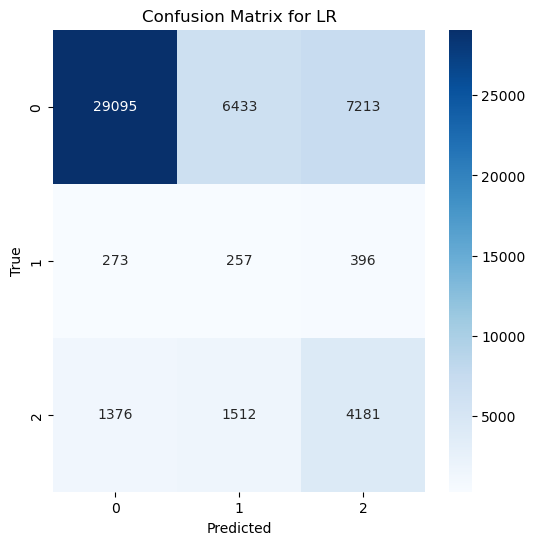

In [4]:
pipeline_final = Pipeline([
    ('preprocessing', preprocessor),
    ('select', SelectKBest(score_func=f_classif, k=17)),
    ('clf', LogisticRegression(C=0.0001, solver='lbfgs', class_weight='balanced', max_iter=1000))
])

pipeline_final.fit(X_train, y_train)

y_pred = pipeline_final.predict(X_test)
f1_BSE = f1_score(y_test, y_pred, average='macro')

print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n === Logistic Regression Evaluation: ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# === 7. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_final.classes_)

print("\n === Confusion Matrix: ===")
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LR')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Decision Tree

### Assumptions we make while using Decision tree

- At the beginning, we consider the whole training set as the root.
- Attributes are assumed to be categorical for information gain and for gini index, attributes are assumed to be continuous.
- On the basis of attribute values records are distributed recursively.
- We use statistical methods for ordering attributes as root or internal node.

https://www.geeksforgeeks.org/decision-tree-implementation-python/

#### Pseudocode 

1. Find the best attribute and place it on the root node of the tree.
2. Now, split the training set of the dataset into subsets. While making the subset make sure that each subset of training dataset should have the same value for an attribute.
3. Find leaf nodes in all branches by repeating 1 and 2 on each subset.

#### Decision Trees doesn't need to me standartised.

Decision Trees (and related models like Random Forests and Gradient Boosted Trees) are not affected by feature scaling. Here's why:

Trees split data based on feature thresholds, not distances or magnitudes.
For example, a decision tree might split on "Feature X > 5" — it doesn't care whether Feature X is in the range [0,1] or [0, 1000].

##### When you do need standardization:
Standardization (using StandardScaler() or MinMaxScaler()) is important for algorithms that are distance-based or gradient-based, such as:

- K-Nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Logistic Regression
- Linear Regression
- Neural Networks

These models are sensitive to feature scale and can perform poorly if features are not standardized.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# X hole data Frame
# y hale data Frame
"""
# === 2. Train/test split === - Janet
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Split training/test - Oliver
X_train, X_test, y_train, y_test = train_test_split(X_selected_rdf, y, test_size=0.2, random_state=42, stratify=y)

# ==== Train/test split ==== - Noah Light
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 2. TRAIN/TEST SPLIT ==== - Noah neuronal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
"""
# Function to split the dataset into features and target variables

def splitdataset(X, y):

    # Splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    """ How they did in on geeksforgeeks.org:
    X_train, X_test, y_train, y_test = train_test_split( 
          X, Y, test_size = 0.3, random_state = 100)
    """

    return X_train, X_test, y_train, y_test 

def Evaluation(y_test, y_pred, y_pred_proba=None):
    
    print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred))
    print("Precision:", sklearn.metrics.precision_score(y_test, y_pred, average='macro'))
    print("Recall:", sklearn.metrics.recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", sklearn.metrics.f1_score(y_test, y_pred, average='macro'))
    if(y_pred_proba):
        print("Log Loss:", sklearn.metrics.log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
    print("Cohen Kappa Score:", sklearn.metrics.cohen_kappa_score(y_test, y_pred))

    # Classification report per classe
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, digits=4))

In [ ]:
# testing first on the hole data set and again with feature selection
X_train, X_test, y_train, y_test = splitdataset(X,y)
#DataSetSplit_Reduced = splitdataset(X_reducedRelevant,y)

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

y_predicted = dtree.predict(X_test)
Accurat = accuracy_score(y_test, y_predicted)
F1 = f1_score(y_test, y_predicted, average='weighted')
print(f"accuracy: {Accurat}")
print(f"F1: {F1}")

X_train, X_test, y_train, y_test = splitdataset(X_postBSE,y)

dtree = DecisionTreeClassifier(max_depth=5)
dtree = dtree.fit(X_train, y_train)

y_predicted = dtree.predict(X_test)
Accurat = accuracy_score(y_test, y_predicted)
F1 = f1_score(y_test, y_predicted, average='weighted')
print(f"accuracy: {Accurat}")
print(f"F1: {F1}")

Evaluation(y_test, y_predicted)
""" ploting desicion tree
plt.figure(figsize=(40, 10))
sklearn.tree.plot_tree(dtree, feature_names=newList)
plt.show()
"""


with backword stepwise elimination

In [ ]:
X_train, X_test, y_train, y_test = splitdataset(X_postBSE,y)

dtree = DecisionTreeClassifier(max_depth=5)
dtree = dtree.fit(X_train, y_train)

y_predicted = dtree.predict(X_test)
Accurat = accuracy_score(y_test, y_predicted)
F1 = f1_score(y_test, y_predicted, average='weighted')
print(f"accuracy: {Accurat}")
print(f"F1: {F1}")

Evaluation(y_test, y_predicted)
""" ploting desicion tree
plt.figure(figsize=(40, 10))
sklearn.tree.plot_tree(dtree, feature_names=newList)
plt.show()
"""

Trying diffrent settings in the DecisionTreeClassifier() function

In [ ]:
def Variating_DecisionTreeClassifier(X_train, y_train, X_test):
    class_weight = ["balanced",None]
    criterions = ["gini", "entropy", "log_loss"]
    maxDepth = [2,4,8,16,32,None]

    maxf1 = 0
    parameters = ""

    for criterion in criterions:
        for d in maxDepth:
            for cl in class_weight:
            
                #print("========= Class weigth:" + str(cl) + " Method: " + criterion + ", maxDepth: " + str(d) + " ========")
                dtree = DecisionTreeClassifier(criterion=criterion, max_depth=d, class_weight=cl)
                dtree.fit(X_train, y_train)
                y_predicted = dtree.predict(X_test)
                if(sklearn.metrics.f1_score(y_test, y_predicted, average='macro') > maxf1):
                    maxf1 = sklearn.metrics.f1_score(y_test, y_predicted, average='macro')
                    parameters = "Criterion:" + criterion + " , depth: " + str(d) + ", class_weight:" + str(cl)
                #print("F1 Score:", sklearn.metrics.f1_score(y_test, y_predicted, average='macro'))

    print("Best result: " + str(maxf1) + " with parameter " + parameters)



Using SMOTE 

In [ ]:
from imblearn.over_sampling import SMOTE

# split hole data set
X_train, X_test, y_train, y_test = splitdataset(X,y)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

Variating_DecisionTreeClassifier(X_train, y_train, X_test)

In [ ]:
#nececcary for same outputs as others?:

#from Oliver:

# Train a Random Forest to get feature importances
# he uses class_weight='balanced'
temp_rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
temp_rdf.fit(X, y)

# Prediction
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
"""
#training a decision tree classifier using the Gini index as the splitting criterion
def train_using_gini(X_train, X_test, y_train):

    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion="gini",
                                      random_state=42, max_depth=3, min_samples_leaf=5)

    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini


def train_using_entropy(X_train, X_test, y_train):

    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
        criterion="entropy", random_state=42,
        max_depth=3, min_samples_leaf=5)

    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy
"""

## Random Forest

In [ ]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, cohen_kappa_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Select the features
rdf_selector = SelectKBest(score_func=mutual_info_classif, k=10)
rdf_selector.fit(X_scaled, y)
X_rdf= rdf_selector.transform(X_scaled)
selected_features = X.columns[rdf_selector.get_support()]

print("Selected features:", selected_features)

# Create a dataframe with the selected features
X_selected_rdf = pd.DataFrame(X_rdf, columns=selected_features, index=data.index)

# RANDOM FOREST
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_selected_rdf, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model
rdf.fit(X_train, y_train)

# Prediction
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))



Random forest feature selection

In [ ]:
# Train a Random Forest to get feature importances
temp_rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
temp_rdf.fit(X, y)

# Get feature importances
importances = temp_rdf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top k important features
k=6
top_features = importance_df['Feature'].head(k).values
print("Top Random Forest Features:", top_features)

# Use only the selected features
X_selected_rf = pd.DataFrame(X, columns=X.columns)[top_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected_rf, y, test_size=0.2, random_state=42, stratify=y)

# Train final model
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
rdf.fit(X_train, y_train)

# Predict
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

HPT after FS RF

In [ ]:
from sklearn.model_selection import StratifiedKFold
#==== Train-test split ====
# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_selected_rf, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)

# ==== Parametri per RandomizedSearch ====
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', {0:1, 1:10, 2:5}, {0:1, 1:15, 2:10}]
}

# ==== RandomizedSearch ====
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ==== Fit ====
random_search.fit(X_train, y_train)


# ==== Best Model ====
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==== Metrics ====
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


HPT for random forest I

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif

"""
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_selector = SelectKBest(score_func=f_classif,k=9)
rdf_selector.fit(X_scaled, y)
X_rdf= rdf_selector.transform(X_scaled)
selected_features = X.columns[rdf_selector.get_support()]

print("Selected features:", selected_features)

# Create a dataframe with the selected features
X_selected_rdf = pd.DataFrame(X_rdf, columns=selected_features, index=data.index)
"""

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)

param_dist = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5, 0.8, None],
    'bootstrap': [True, False]
}

# Random search

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1_macro',  # puoi cambiare qui
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

"""
# Miglior modello
best_rf = random_search.best_estimator_


# Valutazione sul test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)


# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics
print("Best parameters from tuning:", random_search.best_params_)
print("Accuracy:", best_rf.score(X_test, y_test))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
"""

In [ ]:
"""
#  ==== Scaling ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==== Feature selection ====
selector = SelectKBest(score_func=f_classif, k=9)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features, index=data.index)
"""
# ==== Train-test split ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Pipeline ====
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# ==== Parametri per RandomizedSearch ====
param_dist = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False],
    'rf__class_weight': ['balanced', {0:1, 1:10, 2:5}, {0:1, 1:15, 2:10}]
}

# ==== RandomizedSearch ====
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ==== Fit ====
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

"""
# ==== Best Model ====
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==== Metrics ====
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
"""

SMOTE + RF. Let's see

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pipeline con SMOTE + Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit della pipeline sul training set
pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SMOTE + Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier with SMOTE")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

# Classification report per classe
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Let's try an undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


# Pipeline con Undersampling + Random Forest
pipeline = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit della pipeline sul training set
pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Undersampling + Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier with Random Undersampling")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

# Classification report per classe
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

BalancedBaggingClassifier. I'm trying to find a better classifier for very unbalanced dataset. This one uses trained undersample. Let's see

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier

# Balanced Bagging with Random Forest as base estimator
bbc = BalancedBaggingClassifier(
    estimator=RandomForestClassifier(random_state=42),
    sampling_strategy='auto',  # Bilancia automaticamente le classi
    replacement=False,
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# Fit del modello
bbc.fit(X_train, y_train)

# Predizione
y_pred = bbc.predict(X_test)
y_pred_proba = bbc.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (BalancedBaggingClassifier)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Valutazione
print("BalancedBaggingClassifier with RandomForest")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

XGBoost. Also good for very unbalanced dataset

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# Calcolo pesi delle classi per XGBoost
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Inizializza XGBoost
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=1  # Ignorato in multiclass, usiamo sample_weight
)

# Fit con sample_weight
sample_weights = y_train.map(class_weights_dict)
xgb.fit(X_train, y_train, sample_weight=sample_weights)

# Predict
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("XGBoost Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

## Lightgbm

In [ ]:
print(y.value_counts(normalize=True)) ##High imbalance --> Oversampling 
#Plot
plt.figure(figsize=(7, 4))
plt.pie(data['Diabetes_012'].value_counts(), labels=data['Diabetes_012'].value_counts().index,autopct='%1.1f%%' , startangle=140)
plt.title('Distribution of the labels')
plt.legend(title='Diabetes_012')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, cohen_kappa_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
# ==== Preprocessing ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# ==== Selezione delle migliori features ====
selected_cols = multinomial(X_scaled_df)
if 'const' in selected_cols:
    selected_cols.remove('const')
X_model = X_scaled_df[selected_cols]

# ==== Train/test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# ==== Oversampling SMOTE ====
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ==== Calcolo class_weight ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_bal), y=y_train_bal)
class_weight_dict = dict(zip(np.unique(y_train_bal), class_weights))
print("Class weights:", class_weight_dict)

# ==== Modello LightGBM ====
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    learning_rate=0.05,
    n_estimators=300,
    class_weight=class_weight_dict,
    random_state=42
)
model.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(50)]
)

# ==== Predizioni ====
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)

# ==== Valutazione ====
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, digits=4))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ==== Feature Importance ====
importance = model.feature_importances_
feature_names = X_model.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

## Multiclass Classification Neural Network

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ==== 2. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 3. SCALING ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== 4. SMOTE RESAMPLING ====
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

# ==== 5. CUSTOM DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==== 6. MODEL DEFINITION ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)

# ==== 7. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt

# ==== 8. MODEL SETUP ====
model = DiabetesModel(X.shape[1])

# Compute class weights based on inverse frequency (from resampled training set)
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 9. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 10. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 11. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 12. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


